In [1]:
import numpy as np
import pandas as pd
import functions.multi_occupation_network as multi_occupation_network
import matplotlib.pyplot as plt
from  functions.network_figures import bar_plot

# Calibration Excersize 1: Single Occupation

Suppose there is just one type of labor, in other words that $\mathcal{O}=1$. We calibrate our model to mathc BEA input-output tables, and treat the residual, the part of production not accounted for by intermediate inputs, as the labor elasticity. 

In [44]:
data_dir = '../data/clean/'
dfA      = pd.read_csv(data_dir + 'A.csv')
dfParam  = pd.read_csv(data_dir + 'params.csv')
dfLshare = pd.read_csv(data_dir + 'labor_share.csv')
dfLabor_market_yearly= pd.read_csv(data_dir + 'labor_market_yearly.csv')
dfLabor_market_yearly = dfLabor_market_yearly.sort_values(by=['year', 'BEA_sector'])
dfLabor_market_yearly = dfLabor_market_yearly.dropna(axis=0)
dfLabor_market_yearly = dfLabor_market_yearly[dfLabor_market_yearly['year'] == 2005]
# reformatting parameters
Omega = np.array(dfA.iloc[:, 1:], dtype='float64')
Psi = np.linalg.inv(np.eye(Omega.shape[0])-Omega)
J = Omega.shape[0]
O = 1

epsN = np.array(dfParam.α).reshape((J,O))
epsD = np.array(dfParam.θ_alt).reshape((J,1))

# labor market stats
θ = dfLabor_market_yearly['v'].sum() / dfLabor_market_yearly['u'].sum() 
ν = np.ones(O) * 0.5
curlyQ = np.diag(-ν)
curlyF =  np.eye(O) + curlyQ
r = 0.0282
curlyT = np.diag(r / (θ**(-ν) - r))
# NOTE: here I am picking the r so the τ's roughly look right. Down the line, we can calibrate τ directly from the data. 
# Also note that tightness is computed from unemployed workers, but in our model it should be computed from the whole work force.
curlyL = np.array(dfLabor_market_yearly['e']/dfLabor_market_yearly['e'].sum()).reshape((O,J))
curlyT

array([[0.02302957]])

First, we define the shocks we are interested in to allow us to easily change these in the future, that is we define the vectors $d\log\bm{A}$ and $d\log\bm{H}$.

In [3]:
dlog_A = np.zeros((J, 1))
dlog_A[3] = 0.01 
dlog_H = np.zeros((O,1))

We assume Cobb-Douglas production and preferences.

In [4]:
dlog_lam = np.zeros_like(dlog_A)
dlog_epsN = np.zeros_like(epsN)
dlog_epsD = np.zeros_like(epsD)

Finally, we need to make some assumption about how wages change. We begin by assuming that wages net of sectoral employment weighted prices do not change in response to changes in either productivity or the labor force.

In [5]:
#epsW_A = np.zeros((O,J))
gamma_A = 1
gamma_H = 1
epsW_A, epsW_H = multi_occupation_network.WageElasticityFunc(gamma_A, gamma_H, Psi, curlyL, epsN)
epsW_A

array([[0.10656133, 0.02306299, 0.08647666, 0.36979604, 0.02282295,
        0.21167203, 0.17416404, 0.11105386, 0.07859807, 0.11266754,
        0.32066736, 0.06687355, 0.45518659, 0.15413244, 0.11495578,
        0.07581048, 0.05211025]])

In [6]:
dlog_wR = multi_occupation_network.WageFunc(dlog_A, dlog_H, epsW_A, epsW_H)

With these pieces in hand, we can now estimate responses to tightness. For details, see the multiple occupations example code.

In [7]:
curlyE = multi_occupation_network.curlyEFunc(dlog_epsN,epsN)
dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_wR, dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN)
dlog_theta

array([[5.55111512e-17]])

In [8]:
num = 0
dlog_p = multi_occupation_network.PriceFunc(dlog_A, dlog_wR, dlog_theta, Psi, curlyQ, epsN, curlyT, curlyL, num=num)
dlog_p

array([[ 0.00000000e+00],
       [ 1.51291126e-05],
       [-6.33827206e-03],
       [-1.95856091e-02],
       [ 2.42313346e-04],
       [ 8.66557770e-04],
       [-1.18828419e-04],
       [-8.50104220e-05],
       [-1.12048795e-03],
       [-2.78191602e-03],
       [-2.60782739e-03],
       [-9.30805219e-04],
       [ 1.69910558e-04],
       [-1.10237000e-03],
       [ 2.60390345e-04],
       [-6.19598947e-04],
       [ 3.98151742e-04]])

In [9]:
dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, curlyT, curlyE)
dlog_y

array([[0.00189839],
       [0.00188326],
       [0.00823666],
       [0.021484  ],
       [0.00165608],
       [0.00103183],
       [0.00201722],
       [0.0019834 ],
       [0.00301888],
       [0.00468031],
       [0.00450622],
       [0.0028292 ],
       [0.00172848],
       [0.00300076],
       [0.001638  ],
       [0.00251799],
       [0.00150024]])

We can check labor market clearing holds.

In [10]:
multi_occupation_network.LaborSupply(dlog_H, dlog_theta, curlyF) - multi_occupation_network.LaborDemand(dlog_wR, dlog_y, dlog_p, dlog_epsN, curlyL)

array([[8.67361738e-19]])

Finally, we can calculate changes in aggregate output.

In [11]:
dlog_aggY = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)
dlog_aggY

array([[0.00717491]])

Since labor market frictions are the only source of inefficiency in our network economy, in the absence of labor market frictions our network economy is fully efficient. It is well known that Hulten's theorem holds in efficient network economies with Cobb-Douglas technology. We can therefore easily compare the implications of labor market frictions for aggregate output with the implications of the same technology shocks absent labor market frictions.  

In [12]:
epsD.T @ Psi @ dlog_A

array([[0.00717491]])

We can also compare sector level output changes with and without labor market frictions.

## Calibration figures 

### Aggregate importance of deviations from Hulten.

To analyse the quantitative importance of deviations from Hulten's theorem, below we vary $\gamma_A$ from 0 to 2, and plot the aggregate response to a 1\% shock to durable goods.

In [13]:
N=1000
gamma_a_vec = np.linspace(0,2,N)
aggY_vec = np.zeros_like(gamma_a_vec)
dlog_A = np.zeros((J, 1))
dlog_A[3] = 0.01 
dlog_H = np.zeros((O,1))
curlyE = multi_occupation_network.curlyEFunc(dlog_epsN,epsN)


for i in range(N):
    epsW_A, epsW_H = multi_occupation_network.WageElasticityFunc(gamma_a_vec[i], 1, Psi, curlyL, epsN)
    dlog_wR = multi_occupation_network.WageFunc(dlog_A, dlog_H, epsW_A, epsW_H)
    dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_wR, dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN)
    dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, curlyT, curlyE)
    aggY_vec[i] = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)

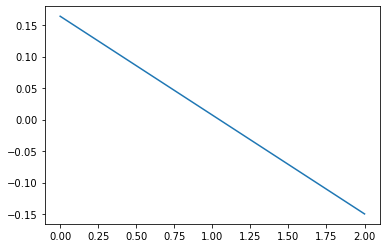

In [14]:
plt.plot(gamma_a_vec,aggY_vec)

Next, we plot responses of sectoral output to technology shocks assuming $\gamma_A = [0.9, 1, 1.1]$. 

In [37]:
gamma_A_vec = np.array([0.95,1,1.05])
sectorY_vec = np.zeros((J+1,3))
sectorT_vec = np.zeros((J,3))
for i in range(3):
    epsW_A, epsW_H = multi_occupation_network.WageElasticityFunc(gamma_A_vec[i], 1, Psi, curlyL, epsN)
    dlog_wR = multi_occupation_network.WageFunc(dlog_A, dlog_H, epsW_A, epsW_H)
    dlog_theta = multi_occupation_network.ThetaFunc(dlog_A, dlog_H, dlog_wR, dlog_epsN, dlog_lam, Psi, Omega, curlyF, curlyQ, curlyT, curlyE, curlyL, epsN)
    sectorT_vec[:, i] = dlog_theta
    dlog_y = multi_occupation_network.OutputFunc(dlog_A,dlog_H, dlog_theta, dlog_lam, Psi, Omega, curlyQ, curlyF, epsN, curlyT, curlyE)
    sectorY_vec[:-1, i] = dlog_y.flatten()
    sectorY_vec[-1, i] = multi_occupation_network.AggOutputFunc(dlog_y, dlog_lam, dlog_epsD, epsD)

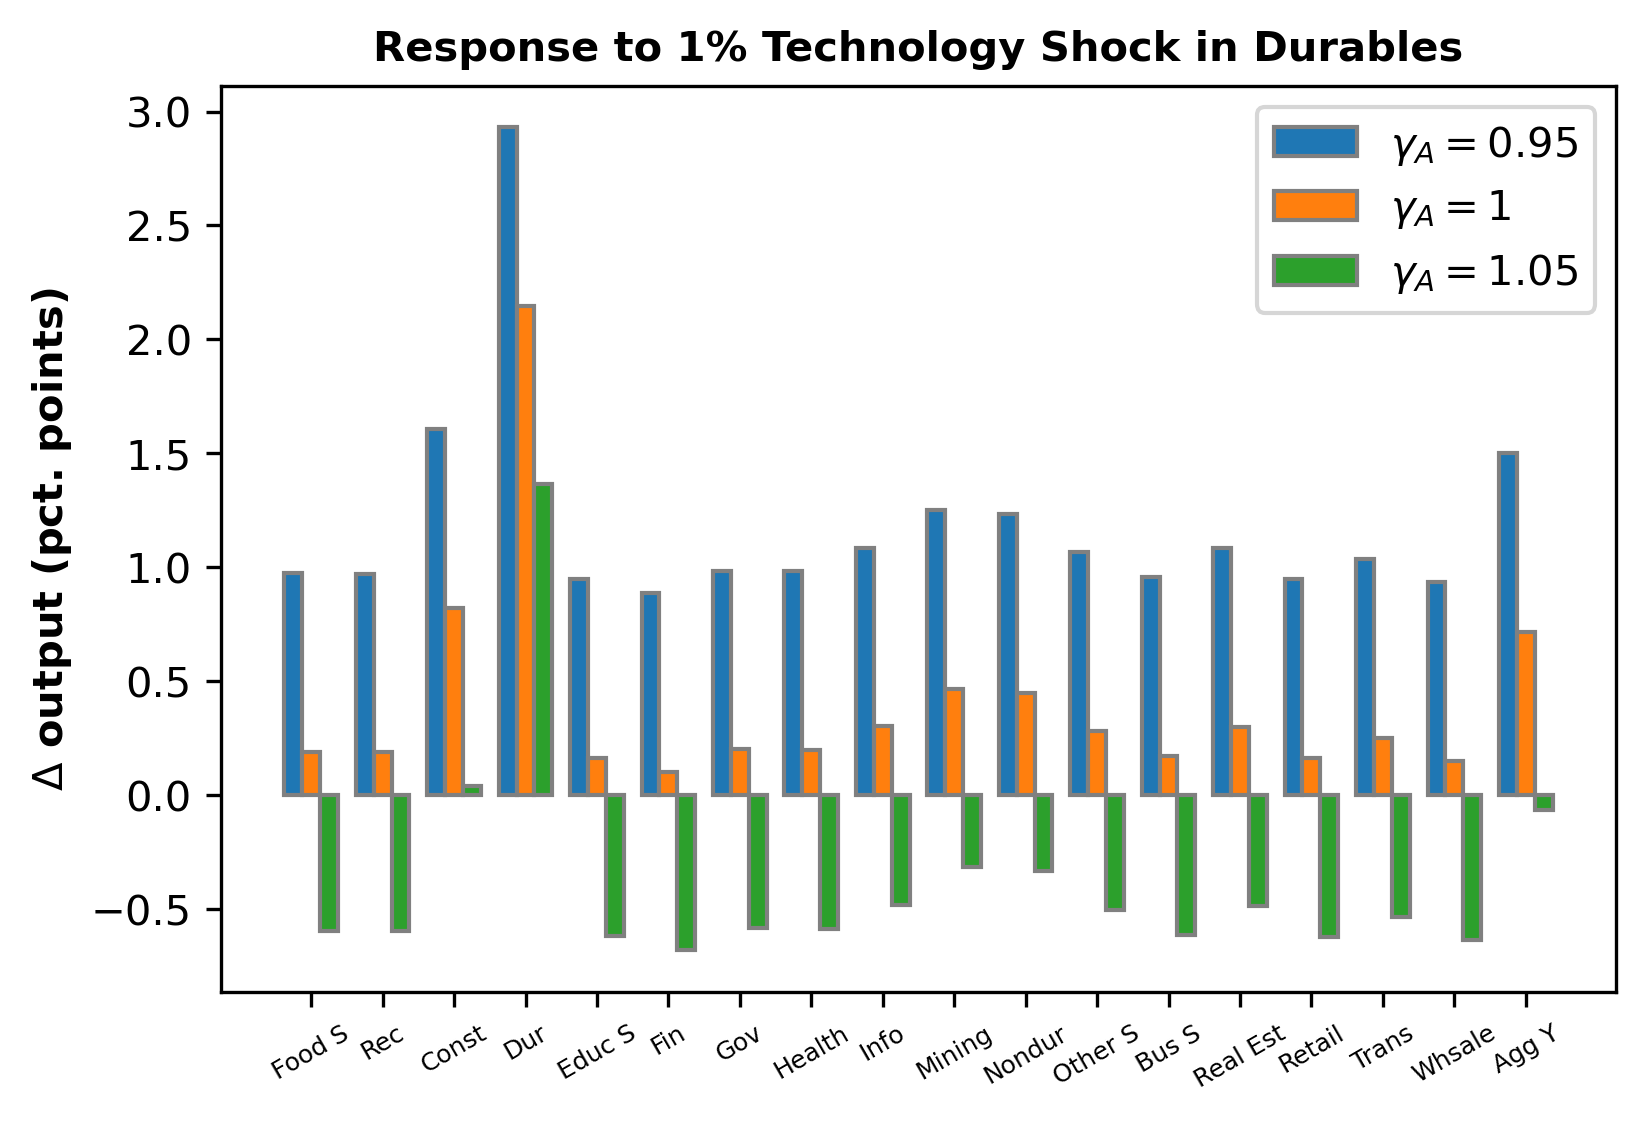

In [39]:
sector_names = ['Food S', 'Rec', 'Const', 'Dur', 'Educ S', 'Fin', 'Gov', 'Health',
           'Info', 'Mining', 'Nondur', 'Other S', 'Bus S', 'Real Est', 'Retail', 'Trans',
           'Whsale', 'Agg Y']
title = 'Response to 1% Technology Shock in Durables'
xlab = ''
ylab = '$\Delta$ output (pct. points)'
save_path = '../output/figures/durables_shockY.png'
labels = ['$\gamma_{A} = 0.95$','$\gamma_{A} = 1$','$\gamma_{A} = 1.05$']
bar_plot(100*sectorY_vec, sector_names, title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.25, dpi=300)

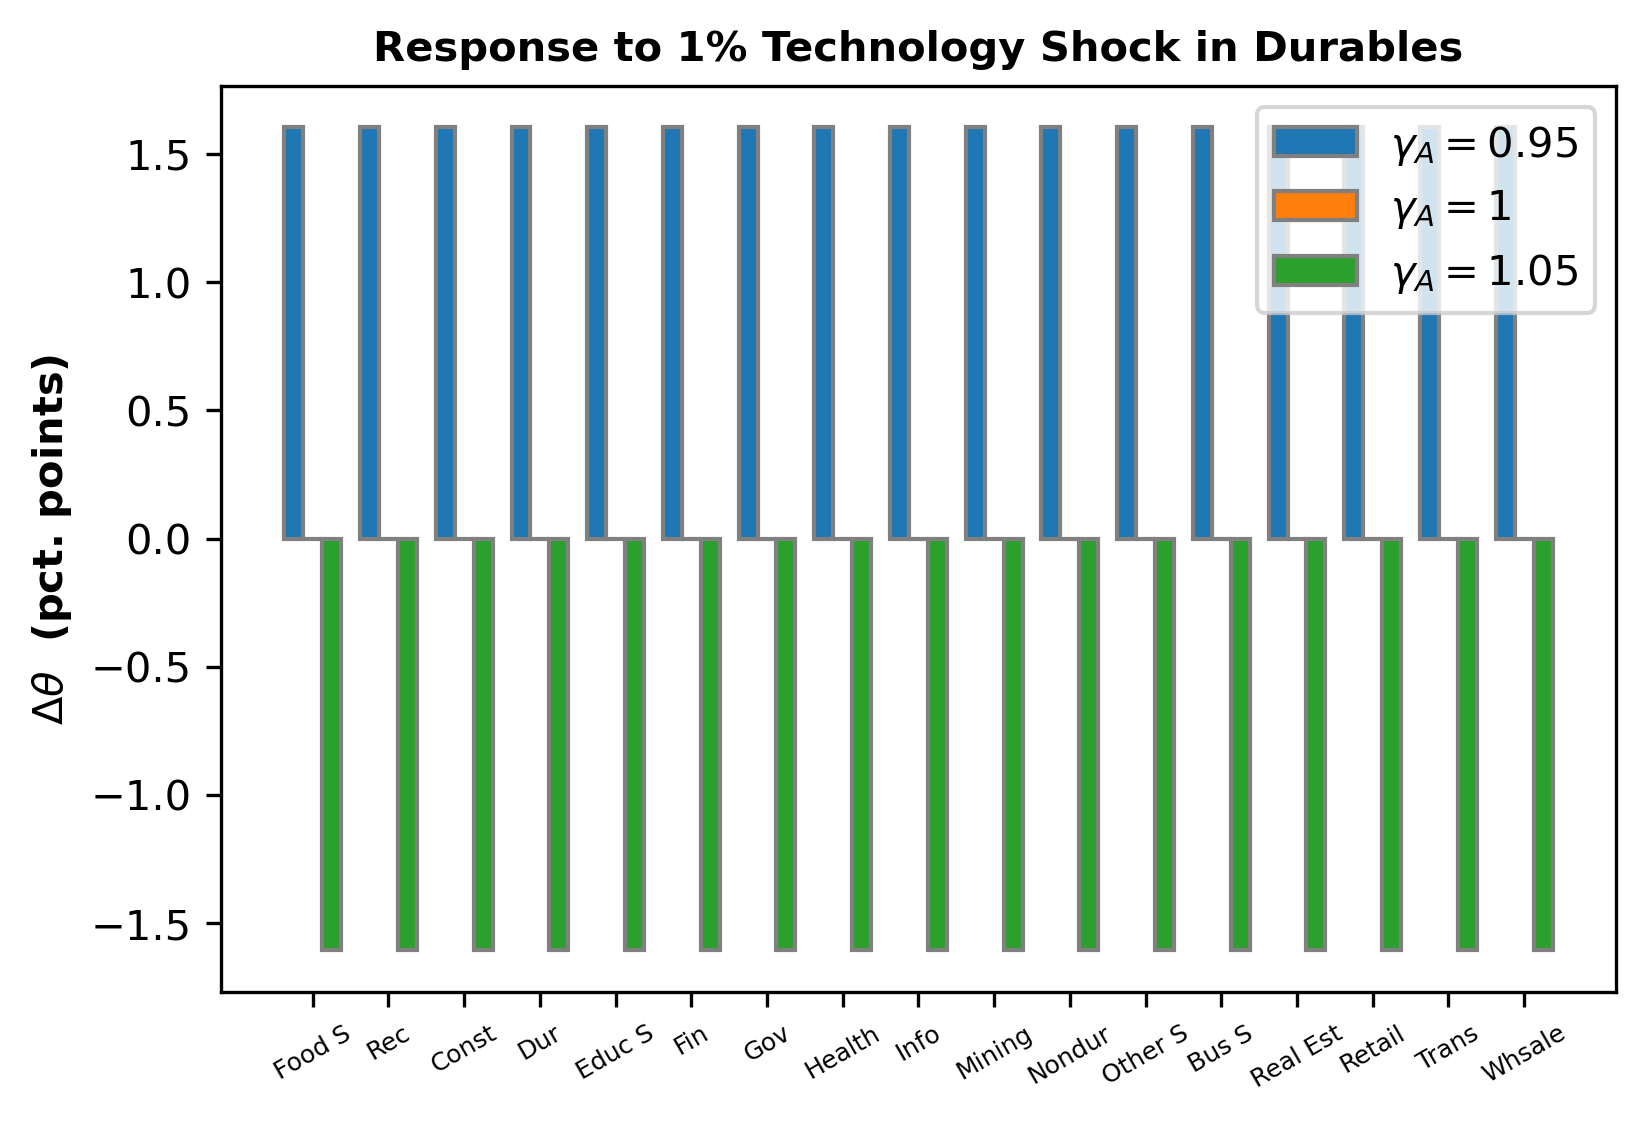

In [43]:
xlab = ''
ylab = '$\Delta \\theta$  (pct. points)'
save_path = '../output/figures/durables_shockT.png'
labels = ['$\gamma_{A} = 0.95$','$\gamma_{A} = 1$','$\gamma_{A} = 1.05$']
bar_plot(100*sectorT_vec, sector_names[:-1], title, xlab, ylab, labels, save_path, rotation=30, fontsize=10, barWidth = 0.25, dpi=300)